# Lab 3 Report

**Author:** Alejandro Alfaro

## Environment Setup
Code in this section help you setup the environment for the subsequent data analysis and visualization. Follow the steps below to perform a one-time setup of your envionrment. This ensures that the visualization code runs without error so make sure you follow these steps **before proceding to the next section**.

1. Run the next cell to make sure the required libraries are ready and up-to-date.
2. Go to `Kernel -> Restart` in the top menu to restart your kernel.
3. To test that everything is working properly, run the two cells following the next one, and confirm that the line plot is showing up. Note that some of you might get a message like `Matplotlib is building the font cache ...` while importing the matplotlib library in the next section. This is normal and will take some time to finish. Just be patient.
4. After confirming that the dummy line plot is showing up, everything is working and you can proceed to the next section. 

If you are still unable to setup the environment after followed all the steps, please report your error to TAs and we will help you debug.

In [12]:
# After the one-time setup is complete, 
# verify your envionrment by running the two cells
# immediately following this cell
#
# Restart your kernel after you finished running this cell!

!pip install -U pip
!python -m pip install -U pip
!pip install -U --user matplotlib numpy scipy

Requirement already up-to-date: pip in c:\users\ctsai\anaconda3\lib\site-packages (18.1)
Requirement already up-to-date: pip in c:\users\ctsai\anaconda3\lib\site-packages (18.1)
Requirement already up-to-date: matplotlib in c:\users\ctsai\appdata\roaming\python\python36\site-packages (3.0.1)
Requirement already up-to-date: numpy in c:\users\ctsai\appdata\roaming\python\python36\site-packages (1.15.3)
Requirement already up-to-date: scipy in c:\users\ctsai\anaconda3\lib\site-packages (1.1.0)


## Import and Verify the Imported Libraries

In [1]:
import numpy as np
from scipy.signal import find_peaks

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

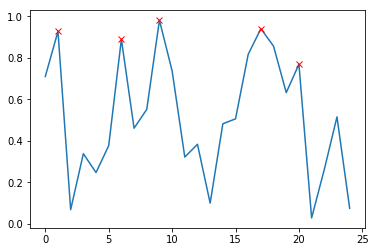

In [2]:
'''
Run this cell to test the numpy, scipy, and matplotlib library. 

You should see a line plot with the peaks marked by red markers
'''
# The code below are used to test whether your matplotlib, numpy, and scipy library is working properly
random_signal = np.random.random(25)
peaks, _ = find_peaks(random_signal, height=np.mean(random_signal))
plt.plot(random_signal)                     # plot the signal
plt.plot(peaks, random_signal[peaks], 'rx') # plot the peaks as red 'x' markers

## Define Helper Functions (make sure your environment is setup)

In [3]:
'''
Several useful helper fucntions have been defined here. 
Feel free to use or modify these functions as you need.
''' 

# Helper function to unpack measurement file
def unpack_data(filename='data.txt'):
    '''unpack_data unpacks measurements and output each column
    
    INPUT:
        filename (str): path to data file to unpack
        
    OUTPUT:
        tuple of all unpacked columns as numpy array
        
    EXAMPLE:
        time_list, temp_list = unpack_data(filename='temperature.txt')             # data file with 2 columns
        time_list, xaxis, yaxis, zaxis = unpack_data(filename='accelerometer.txt') # data file with 4 columns
    '''
    # read file and convert units
    with open(filename, 'r') as file:
        temps = file.read()
    measurements = [m.split(',') for m in temps.split('\n') if len(m) > 2]
    # unpack values and assemble a tuple for output
    # note that the following code assumes you have followed the guideline to put
    # time as the first value in the measurement list
    #
    # process time column
    time_list = [float(m[0]) for m in measurements]
    # Remove initial time offset to make time starts from 0
    time_list = [val-time_list[0] for val in time_list]
    # loop through all remaining columns
    out_tuple = (np.array(time_list),)
    for idx in range(1, len(measurements[0])):
        data_list = np.array([float(m[idx]) for m in measurements])
        out_tuple += (data_list,)
    return out_tuple

def estimate_sample_dt(time_ls):
    '''estimate_sample_dt estimates actual sampling dt measured in data file
    
    INPUT:
        time_ls (list): list containing measured time samples
        
    OUTPUT:
        estimated sampling dt (float)
        
    EXAMPLE:
        dt = estimate_sample_dt(time_list)
    '''
    cum_dt = 0
    for t in range(1, len(time_ls)):
        cum_dt += time_ls[t] - time_ls[t-1]     
    return cum_dt / (len(time_ls)-1)

# Helper function for computing Root mean squared error (RMSE)
def rmse(x, u=0):
    '''estimate_dt estimates actual dt measured in data file
    
    INPUT:
        x (list): list of numbers
        u (number, optional): mean to compare against, default is zero 
        
    OUTPUT:
        rmse error (float)
        
    EXAMPLE:
        rmse_val = rmse(value_list)
    '''
    mse = 0
    for i in range(len(x)):
        mse += (x[i] - u)**2
    return (mse / len(x))**0.5

# Helper function to convert between voltage and raw ADC unit
def adc_to_volt(x): return float(3.3 * x / 65535)
def volt_to_adc(x): return int(65535 * x / 3.3)

# Helper function to do element-wise operations to a list
'''
Input:
    x (list)  : list to operate on
    y (number): number to operate with
    
Output:
    list with each element updated according to the y
    
Example:
    list_plus([1, 2, 3], 10)  # return [11, 12, 13]
    list_plus([1, 2, 3], -1)  # return [0, 1, 2]
    list_mult([1, 2, 3], 2)   # return [2, 4, ]
'''
def list_plus(x, y): return [n+y for n in x] # computes element-wise addition/subtraction by y
def list_mult(x, y): return [n*y for n in x] # computes element-wise multiplication/division by y

## Data Analysis
Process your data here. It involves a couple of different stages (similar to lab 2):

1. Load your data and check your format. The helper functions assume you have followed the exact formatting we asked you to implement during lab 2, which should be in `time, value1, value2, ...\n` format. You are welcome to write your own parser should you chose a different format.
2. Parse the input data fields into `list` to make them easier to process.
3. Process the data according to the requirements and prepare the result for visualizations in the next section.

Make sure you format and comment your code well. This is one important aspect that differentiates good and bad programmers. Python has its unique programming style, this include how comments should be formatted and placed to make you code truely _Pythonic_. The style is referred as **PEP 8** (which means it's the 8th document in the Python Enhancement Proposals index) and is summarized in **[this very short cheatsheet](https://gist.github.com/RichardBronosky/454964087739a449da04)**.

We have included a check list before all the sections below to remind you the work you need to finish. Whenever a new item is finished, edit the markdown cell and put a `x` mark and it will shown as done: `[ ]` means undone, and `[x]` means done.

### Hints
Use the `find_peaks` functions (imported from `scipy` library) to find peaks in the input signal for estimating its frequency.

For example:
```
peaks, _ = find_peaks(v_list, height=np.mean(v_list))
```
will return the index of all peaks that are higher than height which is set to the mean of the list in this specific example. The `, _` means we are discarding the second returned variable since it's not used in our example.

To visually verify the validity of the peaks, simply plot the wave and overlay the peaks
```
plt.plot(time_list, v_list)
plt.plot(time_list[peaks], v_list[peaks], 'rx') # r = red, x = data shown as 'x' markers
plt.xlim([0, 0.2]) # use this to limit the range of x axis
```

To estimate the frequency of the input signal (assume it's a perfect sine wave) you can comput the averaged offset between all peaks, which will be the length of the sine wave in the indices. Then convert the index offset to frequency unit knowing the sampling dt. The following functions from the numpy library could be useful:
```
np.diff([1,2,4,5]) # return the element-wise differential [1,2,1] (which is [2-1, 4-2, 5-4])
np.mean([1,2,3])   # return the average of all elements in the list, 2 in this case
```

### Experiment 1 - Estimate RMSE of wave I/O
Check list:
1. [x] Take measurements for const wave output of voltage 0.0v
2. [x] Take measurements for const wave output of voltage 1.5v
3. [x] Take measurements for const wave output of voltage 3.0v
4. [x] Load all data
5. [x] Process the data and make sure you converted the RMSE unit to milli-volts `mV`
6. [x] Print your result for all the three voltage conditions

In [4]:
'''
Start your work here.
''' 
#Unpack data for the 3 voltage readings
t1_list,v1_list = unpack_data('0V.txt')
t2_list,v2_list = unpack_data('1.5V.txt')
t3_list,v3_list = unpack_data('3V.txt')
dt = estimate_sample_dt(t1_list)
fs = 1 / dt

#Convert the adc readings to voltage
v1 = []
for i in range(len(v1_list)):
    v1.append(adc_to_volt(v1_list[i]))

v2 = []
for i in range(len(v1_list)):
    v2.append(adc_to_volt(v2_list[i]))

v3 = []    
for i in range(len(v1_list)):
    v3.append(adc_to_volt(v3_list[i]))

#Calculate RMSE for the 3 voltage measurement sets
print(rmse(v1,0))
print(rmse(v2,1.5))
print(rmse(v3,3))

 


0.023007244778723145
0.005840666875513967
0.005723943889913809


### Experiment 2 - Estimating Nyquist sampling frequency 1
Check list:
1. [x] Program your `main.py` to output a **25Hz** sine wave
2. [x] Take measurements using any sampling frequency in range `10-500Hz`
3. [x] Load and visualize the measured wave in this notebook
4. [x] If the wave is clearly periodic, compute its frequency (hints provided in previous cells).
5. [x] Repeat item 2-4 until you get an accurate estimate of the minimum sampling frequency required to reconstruct the input wave's frequency.
6. [x] Print your result including the raw wave samples overlayed with the identified peaks (as a plot) and identified sampling frequency.

The frequency of the captured wave is 25.000000Hz
The identified minimum sampling frequncy is 50Hz


Text(0.5, 1.0, '50 Hz sampling frequency Nyquist Plot')

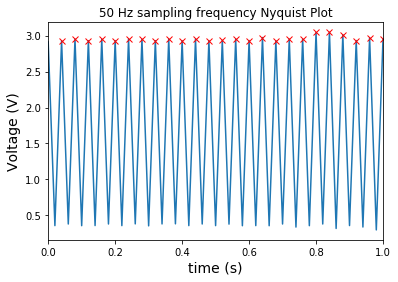

In [5]:
#Unpack data
ts1_list,vs1_list = unpack_data('fs=50.txt')

#Convert adc readings to voltage
vs1 = []
for i in range(len(vs1_list)):
    vs1.append(adc_to_volt(vs1_list[i]))

#Find peaks and place them in a list
vpeaks, _ = find_peaks(vs1, height=np.mean(vs1))

#Calculate mean time between peaks (period) to get the frequency of the wave
peak_offset = np.diff(ts1_list[vpeaks])
mean_peak_offset = np.mean(peak_offset)
frequency = mean_peak_offset
print(f'The frequency of the captured wave is {1/frequency:1f}Hz')
print('The identified minimum sampling frequncy is 50Hz')

#Plot the wave
plt.plot(ts1_list,vs1)
for i in range(len(vpeaks)):
    plt.plot(ts1_list[vpeaks[i]], vs1[vpeaks[i]], 'rx') # r = red, x = data shown as 'x' markers
plt.xlim([0, 1])
plt.xlabel('time (s)', fontsize = '14') 
plt.ylabel('Voltage (V)', fontsize = '14')  
plt.title('50 Hz sampling frequency Nyquist Plot')

### Experiment 3 - Estimating Nyquist sampling frequency 2
Check list:
1. [x] Program your `main.py` to output a compound sine wave consists of a **25Hz** and **50Hz** component (something in the form of `sin(x) + sin(2*x)`, but remember to map to the right output range, more details are provided int the Google Doc).
2. [x] Repeat the same precedure as you did in the last experiment to get an accurate estimate of the minimum sampling frequency required to clearly identify BOTH the 25Hz and 50Hz components (visually, just plot the wave and see if you can identify the two components).
3. [x] Print your identified sampling frequency.
4. [x] Explain the relationship between the two component's frequency and the minimum required sampling frequency

The minimum sampling frequency was identified to be 100Hz


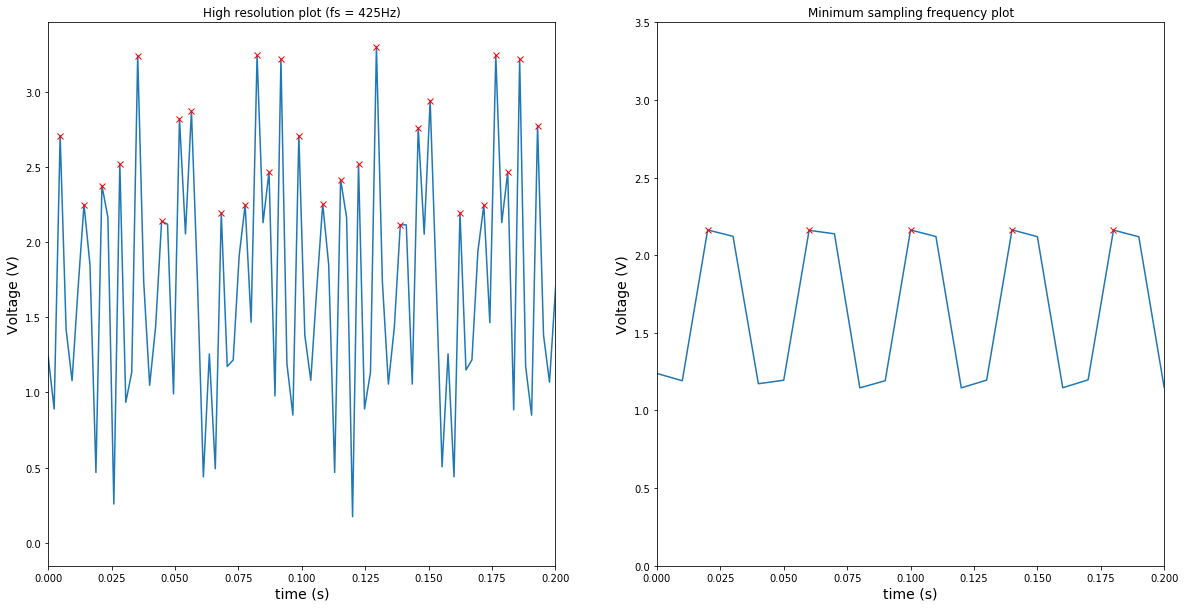

In [6]:
#Unpack minimum sampling frequency data
ts2_list,vs2_list = unpack_data('fs2=100.txt')

#Unpack high resolution data
ts3_list,vs3_list = unpack_data('fs2=425.txt')

#Convert both sets of data into voltage
vs2 = []
for i in range(len(vs2_list)):
    vs2.append(adc_to_volt(vs2_list[i]))   
vpeaks2, _ = find_peaks(vs2, height=np.mean(vs2))


vs3 = []
for i in range(len(vs3_list)):
    vs3.append(adc_to_volt(vs3_list[i]))    
vpeaks3, _ = find_peaks(vs3, height=np.mean(vs3))

#Plot them both and compare
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(ts3_list,vs3)
for i in range(len(vpeaks3)):
    plt.plot(ts3_list[vpeaks3[i]], vs3[vpeaks3[i]], 'rx')
plt.xlim([0, 0.2]) 
plt.xlabel('time (s)', fontsize = '14')  
plt.ylabel('Voltage (V)', fontsize = '14')  
plt.title('High resolution plot (fs = 425Hz)')

plt.subplot(1, 2, 2)
plt.plot(ts2_list,vs2)
for i in range(len(vpeaks2)):
    plt.plot(ts2_list[vpeaks2[i]], vs2[vpeaks2[i]], 'rx') 
plt.xlim([0, 0.2])
plt.ylim([0, 3.5])
plt.xlabel('time (s)', fontsize = '14')  
plt.ylabel('Voltage (V)', fontsize = '14')  
plt.title('Minimum sampling frequency plot')

print('The minimum sampling frequency was identified to be 100Hz')

#The two component frequencies superimpose each other to create a wave that a oscillates at the frequency 
#of the highest frequency wave. In this case it is the 50Hz wave. In a way, the highest frequency dominates
#the lower frequency wave and the sampling frequency has to be modified to accomodate the highest frequency.
#As found in the previous experiment, the minimum sampling frequency is twice the frequency of the wave and
#this was the case for this experiment.

## Quiz

### 1. Nyquist Sampling

#### 1.1 The frequency range for typical human hearing is `20Hz~20KHz`. Explain what is likely the minimum sampling frequency for a recording system to capture any song for playback for human to hear it perfectly (in ideal conditions).

In [ ]:
# Your answer here
print('The minimum sampling frequency is likely  40KHz')
#The theoretical minimum sampling frequency would be 40KHz to capture perfectly the whole frequency range 
#for human hearing. This number comes from the Nyquist frequency which states that the minimum sampling frequency 
#has to be double the captured frequency. In this case it would be 40KHz because 20KHz is the upper bound frequency 
#in the range. However this is theoretical and in practice the minimum sampling frequency would need to be higher. 
#For this reason, Audacity and other audio capturing software have sampling frequencies of 44.1KHz or higher

### 2. ADC (Analog Input)

#### 2.1  What is the smallest voltage change that can be detected (input resolution)? (The ADC resolution in your board is 12bits.)

In [7]:
# 12 bits so data is between 0 and 4095
#Voltage can range between 0 and 3.3V
#resolution would be the voltage range divided by the range of the 12 bit
adc_voltage_resolution = (3.3/4095)*1000  # fill in your answer in mV unit
print(f'The smallest detectable voltage change for the built-in 12bit ADC is {adc_voltage_resolution:.2f} mV')

The smallest detectable voltage change for the built-in 12bit ADC is 0.81 mV


#### 2.2  How do you predict what number you will receive from the ADC if you input a 2.2V signal? (remember: values start at 0, and they are integers).

In [10]:
# Convert the voltage into 12 bits by using the adc voltage resolution above reversed
#Multiply 2.2V by 2^12-1/3.3 and output an integer.
input_value = int(2.2*(4095/3.3))  # fill in your answer here
print(f'The value you will get from the 12bit ADC for a 2.2V input signal is {input_value:d}')

The value you will get from the 12bit ADC for a 2.2V input signal is 2730


### 3. DAC (Analog Output)

#### 3.1 Similar to question 2.1, what is the output resolution? (The DAC resolution in your board is 10bits)

In [11]:
# DAC resolution is 10bits which ranges between 0 and 1023
#Teensy output voltage ranges between 0 and 3.3V
#Divide the voltage range by the 10bits range to get the smallest voltage change
dac_voltage_resolution = (3.3/1023)*1000 
print(f'The smallest voltage change for the built-in 10bit DAC output is {dac_voltage_resolution:.2f} mV')

The smallest voltage change for the built-in 10bit DAC output is 3.23 mV


#### 3.2 How do you predict what voltage you will measure if you output some number, like 34679? (remember: values start at 0, and they are integers)

In [14]:
#Teensy operates as a 16bit and DAC operates as a 10bit
#34679 is a 16bit number so it needs to be convereted into a 10bit and then to a voltage
#using the DAC resolution
output_voltage = int(34679*(1023/65535))*(3.3/1023)
print(f'The voltage you will get from DAC when outputting number 34679 is {output_voltage:2f} V')

The voltage you will get from DAC when outputting number 34679 is 1.745161 V


### 4. Aliasing

#### 4.1 Given an input sine signal of 100Hz, explain what type of wave will you get when sampling at 100Hz and why. Hint: use [this website on the mathematics of alias frequencies](https://goo.gl/y9mkd)  to help you formulate your answer

If you need to type pretty math formulas, use LaTeX math input like this [(Cheat sheet is provided here)](https://reu.dimacs.rutgers.edu/Symbols.pdf).

A separated equation
$$
f_a(N) = |f_{in} - N * f_s|
$$


A wave of 0Hz would be outputted as predicted by the equation above. This would be represented by a straighline DC wave. In mathematical terms this would be the case because N in the equation above would equal to 1 giving a results for the alias frequency of 0Hz.



#### 4.2 Under the same condition as 4.1, what will be the alias frequency if your sampling frequency is changed to 125Hz? Hint: use [this website on the mathematics of alias frequencies](https://goo.gl/y9mkd)  to help you formulate your answer

If you need to type pretty math formulas, use LaTeX math input like this [(Cheat sheet is provided here)](https://reu.dimacs.rutgers.edu/Symbols.pdf).

A separated equation
$$
f_a(N) = |f_{in} - N * f_s|
$$


N would still remain 1 in this case because 125 is closer to 100 than 200. Pluggin in the values into the equation above will give an alias frequency of 25Hz

## Appendix

### Source Code for Data Acquisition (include only main.py)

In [ ]:
###############################################
############### Library Imports ###############
###############################################
import board
import time
from analogio import AnalogIn
import array
from math import pi, sin
import audioio
#from adafruit_dotstar import DotStar
from neopixel import NeoPixel
import gc
gc.collect() # garbage collection, make some room for our programimport microcontroller 
        

###########################################################
############### Global Score Initialization ###############
###########################################################
### Global constants
VOLTAGE_TO_DAC = 65535 / 3.3

### Neopixel colors [R, G, B]
COLOR_RED = [255, 0, 0]
COLOR_GREEN = [0, 255, 0]
COLOR_BLUE = [0, 0, 255]
COLOR_ORANGE = [255, 165, 0]
COLOR_YELLOW = [255, 255, 0]
COLOR_CYAN = [0, 255, 255]

### Initialize Neopixel and DotStar
neopixels = NeoPixel(board.D7, 1, brightness=0.1, auto_write=True)
#dotstar = DotStar(board.APA102_SCK, board.APA102_MOSI, 1, brightness=0.5, auto_write=True)

### Allocate memory for data acquisition, the EAFP way!
sample_buffer = array.array("H", []) # 'H' = unsigned short
try:
   # Insert a zero to the end of the list until fail
   while len(sample_buffer) < 1000: sample_buffer.append(0)
except: pass
MEM_BLOCK_SIZE = len(sample_buffer)
print("Allocated memory size: {0:d}".format(MEM_BLOCK_SIZE))

### Wave IO
waveOut = audioio.AudioOut(board.A0) # Wave out
waveIn = AnalogIn(board.A5)          # Wave in

####################################################
############### Function Definitions ###############
####################################################
def set_wave_output(static=False, v_out=1.1, sine_freq=50):
   # Note that when static=True, you only specify v_out and no
   # third argument. When static=False, you specify on sine_freq
   wave_sample_rate = 8000  # samples/second
   # Generate samples needed for one cycle of the output wave
   samples_per_wave = wave_sample_rate // sine_freq  
   wave_array = array.array("H", [0] * samples_per_wave) # 'H' = unsigned short
   for i in range(samples_per_wave):
       if static:
           # Static wave samples
           wave_array[i] = int(v_out*VOLTAGE_TO_DAC)
       else:
           # Sine wave samples
           wave_array[i] = int(1.65*VOLTAGE_TO_DAC*(sin(2*pi*i/samples_per_wave)+sin(4*pi*i/samples_per_wave))+VOLTAGE_TO_DAC*1.65)
   wave_array = audioio.RawSample(wave_array, sample_rate=wave_sample_rate)
   waveOut.play(wave_array, loop=True) # start playing the output wave

def set_neopixel_color(color=[0, 0, 0]):
   neopixels.fill(color)
   #dotstar.fill(color)
  
def measurement_session(filename='measurement.txt', samp_fs=100, max_sample_time=10, print_to_file=False):
    set_neopixel_color(COLOR_BLUE)
    samp_dt = 1 / samp_fs
    num_samples = MEM_BLOCK_SIZE
    ## Loop 1: Fill the memory block with samples (runs super fast)
    # cap the total amount of samples if we don't need that much
    if max_sample_time*samp_fs < num_samples: 
        num_samples = max_sample_time * samp_fs
    # start sampling
    for i in range(num_samples):
        time_sample = time.monotonic()
        sample_buffer[i] = waveIn.value
        while time.monotonic() < time_sample+samp_dt: 
            pass # wait until the dt has passed
    ## Loop 2: Save data
    set_neopixel_color(COLOR_CYAN)
    try:
        time_start = 0
        if print_to_file:
            fp = open(filename, "w")
        for i in range(num_samples):
            sample = "{0:.5f}, {1:.d}\n".format(time_start+i*samp_dt, sample_buffer[i])
            if print_to_file: 
                fp.write(sample)
            else: 
                print(sample)
        if print_to_file: 
            fp.close()
    except OSError:
        set_neopixel_color(COLOR_RED)
        while True: pass
  
#
############### Main Loop ###############
#########################################
set_neopixel_color(COLOR_GREEN)


set_wave_output(static=False, sine_freq=25)     # use this to output a 1.0v static wave
# set_wave_output(static=False, sine_freq=10) # use this to output a sine wave at 10Hz

measurement_session(filename='fs2=113.txt', samp_fs=113, max_sample_time=5, print_to_file=True)
measurement_session(filename='fs2=106.txt', samp_fs=106, max_sample_time=5, print_to_file=True)
measurement_session(filename='fs2=103.txt', samp_fs=103, max_sample_time=5, print_to_file=True)
#measurement_session(filename='fs2=.txt', samp_fs=125, max_sample_time=5, print_to_file=True)